<a href="https://colab.research.google.com/github/mawady/colab-recipes-cv/blob/main/ObjectDetection_Infer_YoloV3_COCO_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Info
Developed by Dr. Mohamed Elawady - [[Website](https://mawady.github.io)] - [[Linkedin](https://www.linkedin.com/in/mawady/)]

---

# Object detecton using YoloV3(OpenCV) - Inference
- https://github.com/spmallick/learnopencv/tree/master/ObjectDetection-YOLO
- https://github.com/opencv/opencv/tree/master/samples/dnn

In [ ]:
!pip install opencv-python-headless==4.5.4.60

In [ ]:
# Download models: yolov3.weights
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights

# Download model structure: yolov3.cfg
!wget -O yolov3.cfg https://raw.githubusercontent.com/spmallick/learnopencv/master/ObjectDetection-YOLO/yolov3.cfg

# Download class names: coco.names
!wget -O coco.names https://raw.githubusercontent.com/spmallick/learnopencv/master/ObjectDetection-YOLO/coco.names

# https://upload.wikimedia.org/wikipedia/en/3/32/Times_Square_0210.JPG
# Download an image example
!wget -O input.jpg https://upload.wikimedia.org/wikipedia/en/3/32/Times_Square_0210.JPG
input_path = '/content/input.jpg'
# print("Please upload input image to predict:")
# upload_input = files.upload()
# path_input = "/content/{}".format(list(upload_input.keys())[0])

--2021-12-24 18:42:19--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.4MB/s    in 11s     

2021-12-24 18:42:31 (21.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2021-12-24 18:42:31--  https://raw.githubusercontent.com/spmallick/learnopencv/master/ObjectDetection-YOLO/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8341 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --

In [ ]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
from google.colab.patches import cv2_imshow

In [ ]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

In [ ]:
# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

import torch
use_cuda = torch.cuda.is_available()

if use_cuda:
  net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
  net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)
  print('Using GPU device.')
else:
  net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
  net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
  print('Using CPU device.')

Using GPU device.


In [ ]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(frame,classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 2)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX,0.5, (0,0,0), 2)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(frame,classIds[i], confidences[i], left, top, left + width, top + height)


Inference time: 1682.39 ms


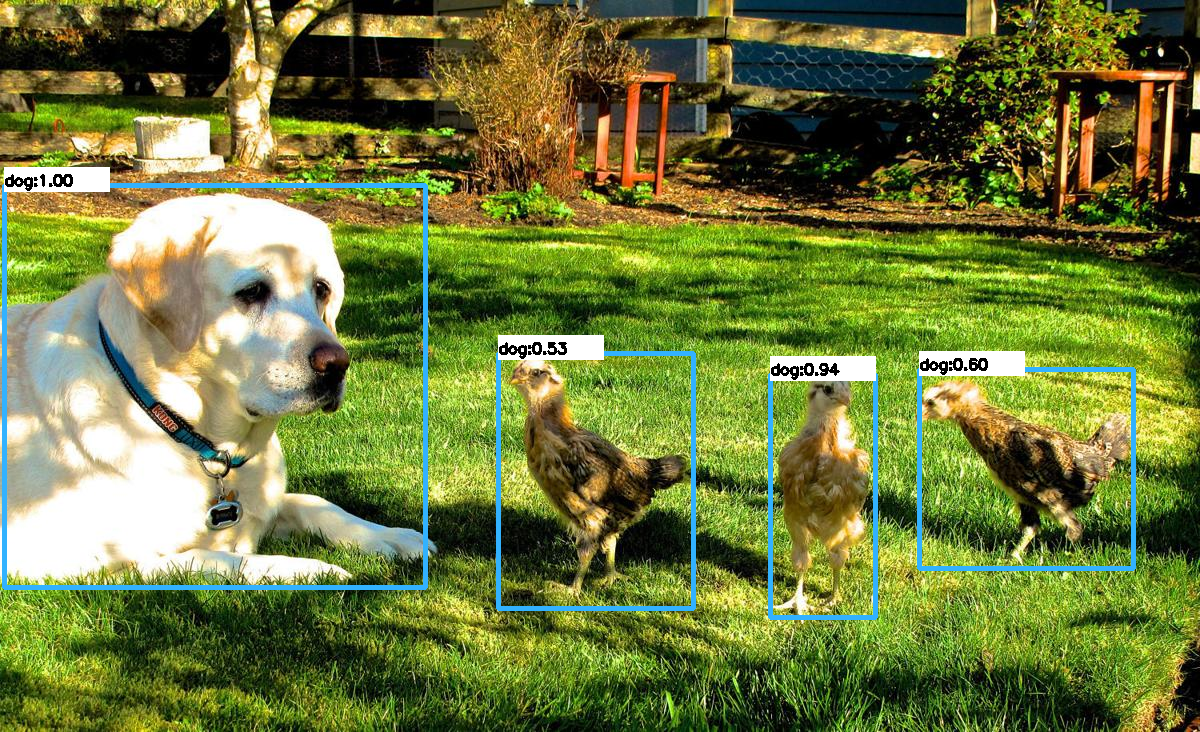

In [ ]:
# Read image
img = cv.imread(input_path)
# cap = cv.VideoCapture(input_path)
# hasFrame, img = cap.read()
outputFile = input_path[:-4]+'_yolo_out_py.jpg'
# Create a 4D blob from a frame.
blob = cv.dnn.blobFromImage(img, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))

# Remove the bounding boxes with low confidence
postprocess(img, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
# cv.putText(img, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
print(label)

# Write the frame with the detection boxes
cv.imwrite(outputFile, img.astype(np.uint8))

cv2_imshow(img)
